In [183]:
import pandas as pd
import numpy as np

import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

from os.path import join
import os

In [184]:
file_path = './train.csv'
df = pd.read_csv(file_path)
print(df.shape)
df.head()

(15035, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [185]:
file_path = './test.csv'
X_test = pd.read_csv(file_path)
print(X_test.shape)
X_test.head()

(6468, 20)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


<AxesSubplot:xlabel='price', ylabel='Density'>

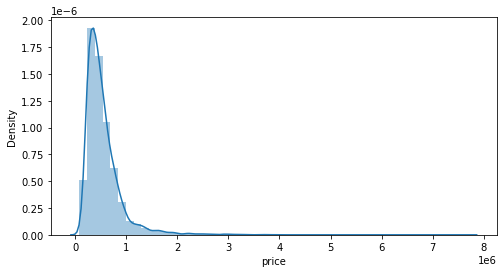

In [186]:
fg, ax = plt.subplots(figsize=(8, 4))
sns.distplot(df['price'])


<AxesSubplot:xlabel='price', ylabel='Density'>

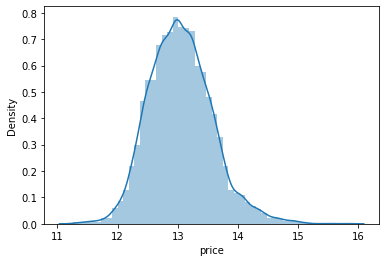

In [187]:
df['price'] = np.log1p(df['price'])
sns.distplot(df['price'])

In [188]:
y_train = df['price']
del df['price']

In [189]:
train_len = df.shape[0]
test_id = X_test['id']
df = pd.concat((df, X_test), axis=0)
df.shape

(21503, 20)

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21503 non-null  int64  
 1   date           21503 non-null  object 
 2   bedrooms       21503 non-null  int64  
 3   bathrooms      21503 non-null  float64
 4   sqft_living    21503 non-null  int64  
 5   sqft_lot       21503 non-null  int64  
 6   floors         21503 non-null  float64
 7   waterfront     21503 non-null  int64  
 8   view           21503 non-null  int64  
 9   condition      21503 non-null  int64  
 10  grade          21503 non-null  int64  
 11  sqft_above     21503 non-null  int64  
 12  sqft_basement  21503 non-null  int64  
 13  yr_built       21503 non-null  int64  
 14  yr_renovated   21503 non-null  int64  
 15  zipcode        21503 non-null  int64  
 16  lat            21503 non-null  float64
 17  long           21503 non-null  float64
 18  sqft_li

<AxesSubplot:>

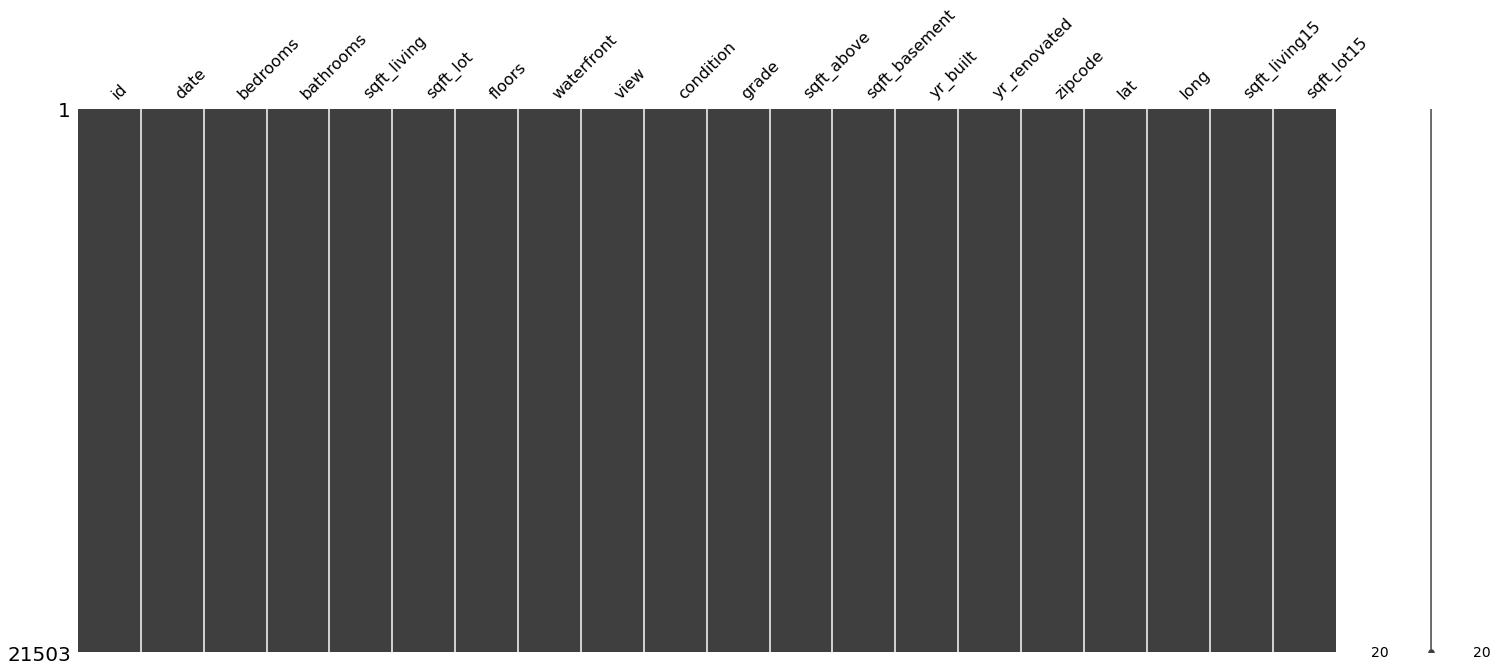

In [191]:
msno.matrix(df)

In [192]:
del df['id']
df['date'] = df['date'].apply(lambda x: int(x[:6]))

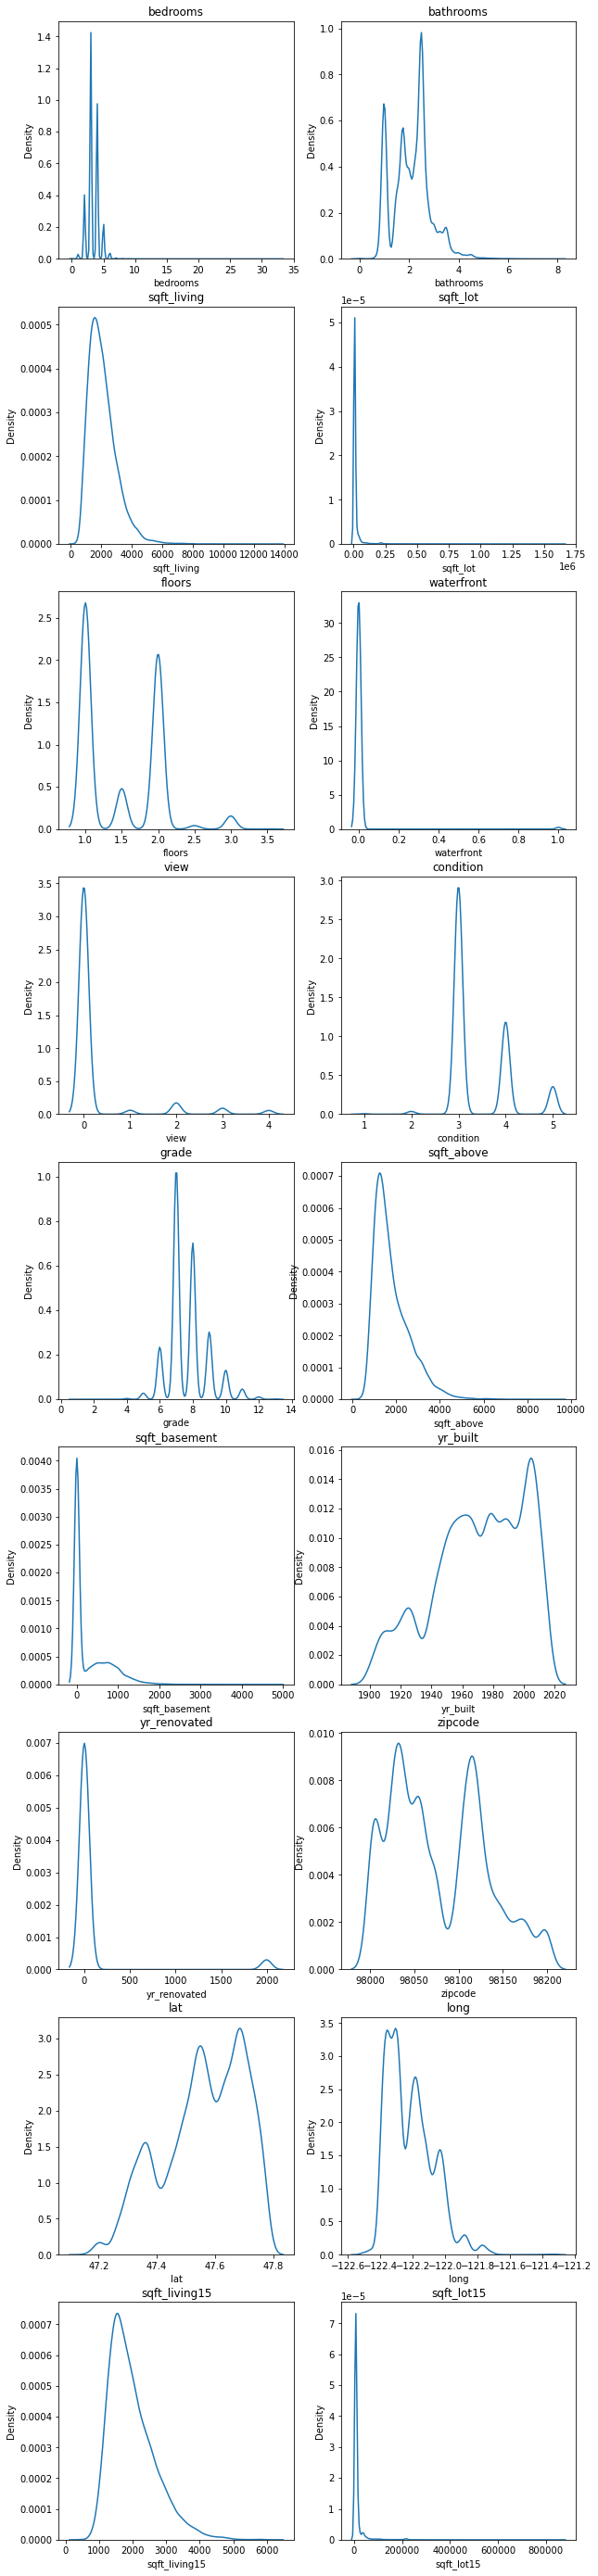

In [193]:
fig, ax = plt.subplots(9, 2, figsize=(10, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = df.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=df[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=12)
        count += 1

In [194]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    df[c] = np.log1p(df[c].values)

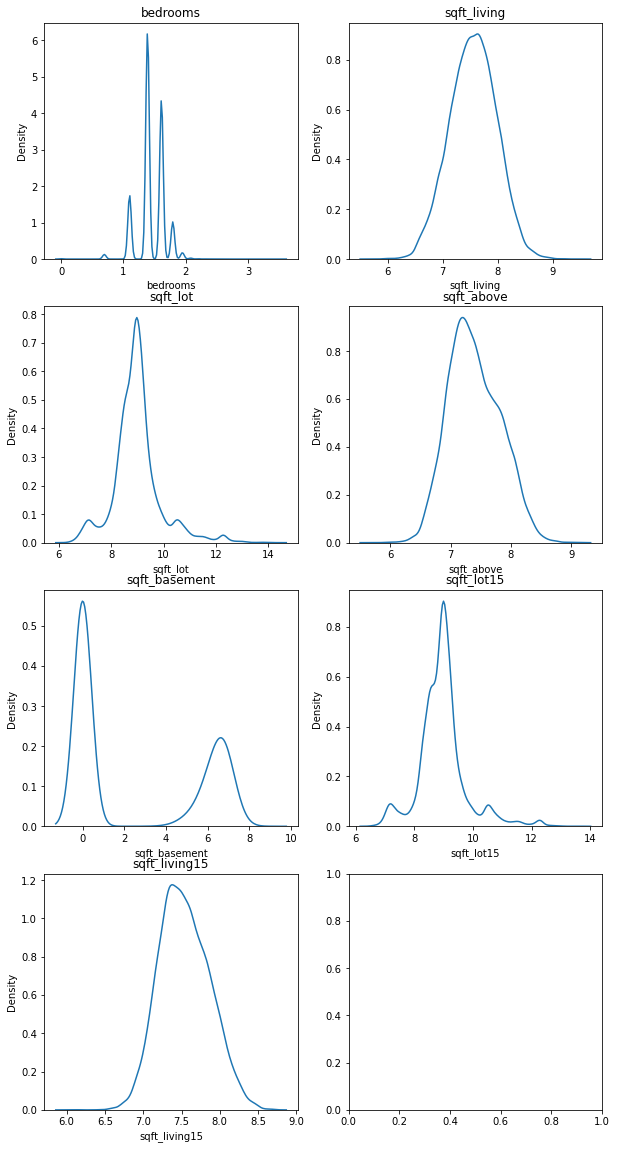

In [195]:
f, ax = plt.subplots(4, 2, figsize=(10, 20))

count = 0
for i in range(4):
    for j in range(2):
        sns.kdeplot(data=df[skew_columns[count]], ax=ax[i][j])
        ax[i][j].set_title(skew_columns[count], fontsize=12)
        count += 1
        if count == 7:
            break


In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  int64  
 1   bedrooms       21503 non-null  float64
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  float64
 4   sqft_lot       21503 non-null  float64
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  float64
 11  sqft_basement  21503 non-null  float64
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  float64
 18  sqft_lo

<AxesSubplot:>

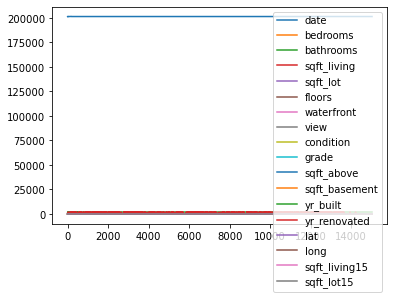

In [197]:
del df['zipcode']
X_train, X_test = df.iloc[:train_len], df.iloc[train_len:]

In [198]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

In [199]:
y_pred = model.predict(X_test)

In [1]:
result = pd.DataFrame({
    'id' : test_id, 
    'price' : y_pred
})

data_dir = os.getenv('HOME')
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

NameError: name 'pd' is not defined

# 회고

시간이 없어서 끔찍한 결과를 만들었다.
캐글 제출 결과는 github 상위 디렉터리에 넣었습니다. 로컬에서 어떻게 올리는지 모르겠네요

